# Imports

In [33]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from utility_functions import *

import requests
from io import BytesIO

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Load the data into train and test sets

In [20]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

## Example of pictures

y = 0. It's a non-cat picture.


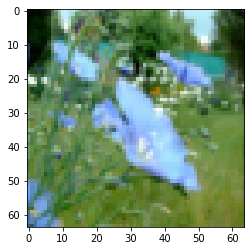

In [21]:
# Example of a picture
index = 20
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

## Exploring the dataset

In [22]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


## Reshape the training and test examples

In [23]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


# L layer model

## Using a 4 layer model

In [24]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
# 12288 is the number of x inputs
# 20 is the number of nodes on the first layer
# so on...

### L layer model function

In [25]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
        
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [26]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)
print("Cost after first iteration: " + str(costs[0]))


Cost after iteration 0: 0.7717493284237686
Cost after first iteration: 0.7717493284237686


# Training the model

In [27]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463302
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005212
Cost after iteration 2000: 0.11382060668633713
Cost after iteration 2100: 0.1078392

## Predicting output from training set

In [28]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


## Predicting output from test set

In [30]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


# Testing with an online image

In [52]:
def is_cat(url, is_it_cat = 1):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    image_array = np.array(img.resize((num_px,num_px)))
    plt.imshow(image_array)

    #Normalize the image
    #my_label_y = [1]
    image_array = image_array / 255
    image_array = image_array.reshape(num_px*num_px*3, 1)

    output_prediction = predict(image_array, is_it_cat, parameters)

    print("y = " + str(np.squeeze(output_prediction)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(output_prediction)),].decode("utf-8") +  "\" picture.")

Accuracy: 1.0
y = 1.0, your algorithm predicts a "cat" picture.


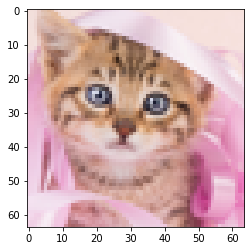

In [51]:
is_cat("https://i.imgur.com/jOAc2Le.png", 1)

Accuracy: 0.0
y = 0.0, your algorithm predicts a "non-cat" picture.


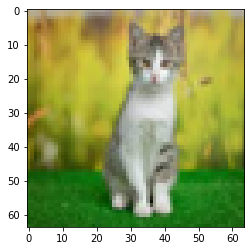

In [53]:
is_cat("https://i.imgur.com/6Xn6xKf.png", 1)

Accuracy: 1.0
y = 1.0, your algorithm predicts a "cat" picture.


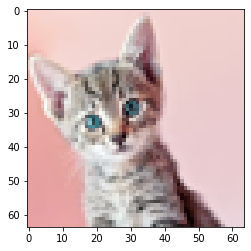

In [54]:
is_cat("https://i.imgur.com/ei1UCTn.png", 1)

Accuracy: 1.0
y = 1.0, your algorithm predicts a "cat" picture.


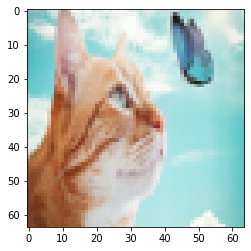

In [55]:
is_cat("https://i.imgur.com/6UNIuWb.jpg", 1)